# Recsys Data Analysis

This notebook analyzes the results of different datasets and different recomendation algorithms in order to stablish a baseline for Lenskit.

## Setup

First, we need to import our libraries:

In [67]:
import pandas as pd
import matplotlib
import numpy as np
import os

In [68]:
%matplotlib inline

## Datasets

We use the following datasets for our analysis

### LastFM

- Users: 1892 users
- Items: 17632 artists

This dataset contains 92.834 user-artist relations. The weight of the graph’s edges represents amount of plays. We considered these weights as ratings.

In this iteration of the analysis we did not normalize the numbers into a [1,5] scale. It can be done by classifying each relation into its respective quintile. This approach, however, has the drawback of discretizing something that is very continuous; for example, relationships that are on the upper scale of a quintile are qualitatively similar to those on the lower scale of the next quintile, but we are losing that information. Another consequence (which may not be a problem, but it is an interesting result nonetheless) is that each class will have exactly the same amount of members (relationships). As datasets that include a normal rating system often do not have this property, it may be appealing to run the algorithms on this normalized dataset.

Another approach is inspired by the Mahalanobis distance; in essence, calculate the mean of the ratings and for each rating calculate how many standard deviations it strays from the mean. Those that are deviated to higher values are assigned a value near to 5 and ratings that deviate from the mean but by being lower are assigned values near to 1. This might have the effect of having ratings form a normal distribution, which is also not common in “true” rating datasets.

### Movielens-1k
- Users: 943 users 
- Items: 1682 movies

This dataset contains 100.000 user-movie relations. Each relation represents the evaluation of a movie by a user (in a scale from 1 to 5).

### Jester


- Users: 73.495 users
- Items: 100 jokes

This dataset contains 4.1 million of user-joke relations. Each relation represents the evaluation of a movie by a user (in a scale from -10.0 to 10.0). As the scale is different to the used in Movielens, we decided to normalized the evaluations to a scale of [1,5].
This dataset is really unique as the number of items, in this case jokes, is only 100. One of the consequences of this property is that the user-item matrix is not as sparse as it normally is elsewhere. It wouldn’t be unusual for one user to have rated a majority of the items; in contrast, this would have been unthinkable in other datasets like MovieLens or Amazon-Books. The quantitative characterization of this dataset (and the rest) remains as future work (see conclusions for details).

### Bookcrossing

- Users: 278.858 users
- Items: 271.379 books

This dataset contains 1.149.780 of user-book relations. Each relation represents the evaluation of a book by a user.


## Results

The results for each dataset is stored in a `csv` file.
We ran each algorithm 5 times since we used 5-fold cross-validation.  What we want to do next is compute the average value of each metric for each data set.

In [182]:
datasets = ['lastfm','movielens','jester']
results = pd.DataFrame()
for dataset in datasets:
    aux = pd.read_csv('data-analysis/results/'+dataset+'/eval-results.csv')
    aux['Dataset'] = dataset
    if results.empty : results = aux
    else: results = results.append(aux)

agg_results = results.drop(['Partition'], axis=1).groupby(['Dataset','Algorithm']).mean()
agg_results


BuildTime    TestTime  RMSE.ByUser  RMSE.ByRating  \
Dataset   Algorithm                                                      
jester    Custom        0.7688      3.6016     0.826559       0.876547   
          FunkSVD     275.6342      5.4392     0.777133       0.820905   
          ItemItem      6.8920     13.6160     0.790791       0.834246   
          PersMean      0.2014      4.6386     0.826559       0.876547   
          UserUser      0.0562  46752.3962     0.796242       0.837172   
lastfm    Custom        0.0652      3.9202  1225.316632    3052.545397   
          FunkSVD       6.0048     11.1364          NaN            NaN   
          ItemItem      4.3300     22.1684  1455.425755    4469.689135   
          PersMean      0.0980      8.5226  1225.316632    3052.545397   
          UserUser      0.0660     20.7732  1226.077364    3251.001417   
movielens Custom        0.0924      0.7654     0.920828       0.938236   
          FunkSVD      17.7272      1.2894     0.912880       0.927017   
          ItemItem      9.3392     22.4264     0.890329       0.896983   
          PersMean      0.2258      1.3900     0.920828       0.938236   
          UserUser      0.1492     30.6152     0.915197       0.924923   

                     Predict.nDCG       MRR  
Dataset   Algorithm                          
jester    Custom         0.944487  0.626766  
          FunkSVD        0.953069  0.613710  
          ItemItem       0.950978  0.618007  
          PersMean       0.944487  0.626754  
          UserUser       0.951187  0.715006  
lastfm    Custom         0.811768  0.000650  
          FunkSVD        0.754774  0.004653  
          ItemItem       0.734481  0.001663  
          PersMean       0.811768  0.000650  
          UserUser       0.743537  0.001729  
movielens Custom         0.949941  0.002643  
          FunkSVD        0.951345  0.004229  
          ItemItem       0.955260  0.095015  
          PersMean       0.949941  0.002643  
          UserUser       0.953311  0.003774

## Metrics

For each metric we get the value accross each dataset. Showing it normalized and with original values

In [240]:
import pandas
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

def print_metric(m):
    plt.figure(figsize=(14,7))
        
    metric_data = agg_results.reset_index().pivot(index='Algorithm', columns='Dataset', values=m).reset_index().fillna(0)
    parallel_coordinates(metric_data, 'Algorithm',colormap="Set1",linewidth=2);
    plt.title(m + 'by Dataset and Algorithm')

    plt.show()
   

    algo = metric_data['Algorithm']
    aux = metric_data.drop('Algorithm',1)
    metric_data_norm = (aux - aux.min()) / (aux.max() - aux.min())
    metric_data_norm.loc[:,'Algorithm']=algo
    plt.figure(figsize=(14,7))
    parallel_coordinates(metric_data_norm, 'Algorithm',colormap="Set1",linewidth=2);

    plt.title(m + ' Normalized by Dataset and Algorithm')
    plt.show()




### RMSE

RMSE reflects the difference between the real values and those predicted by the algorithm. It is calculated in two ways:

- Grouped by user: RMSE.byUser 

\begin{equation}
    \frac{\displaystyle\sum_{\forall u\in U}\sqrt{\frac{\displaystyle\sum_{\forall r \in R} err_{ru}^2}{|R_u|}}}{|U|}
\end{equation}


- Globally: RMSE.byRating

\begin{equation}
    \sqrt{\frac{\displaystyle\sum_{\forall u \in U}\displaystyle\sum_{\forall r \in R} err_{ru}^2}{|R|}}
\end{equation}

In general, both ways gives similar results.

In the case of LastFM, while grouping by users, the results are approximately a third of those obtained using the Global expression. And it is interesting to see that the values are enormous in comparison to those obtained with Movielens and Jester.

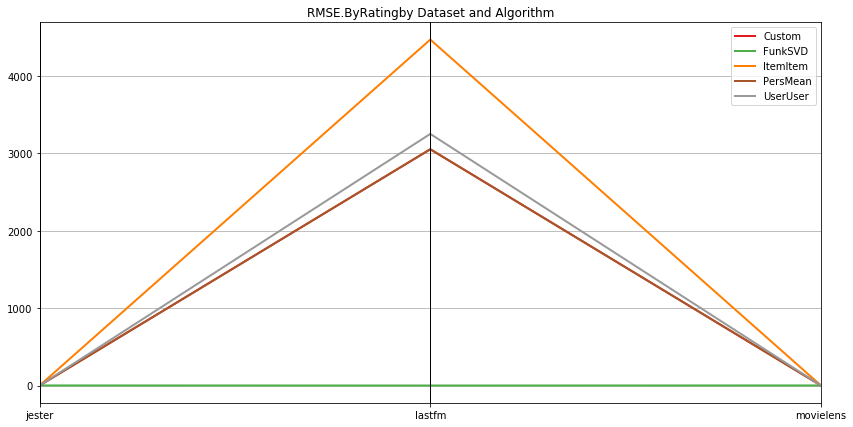

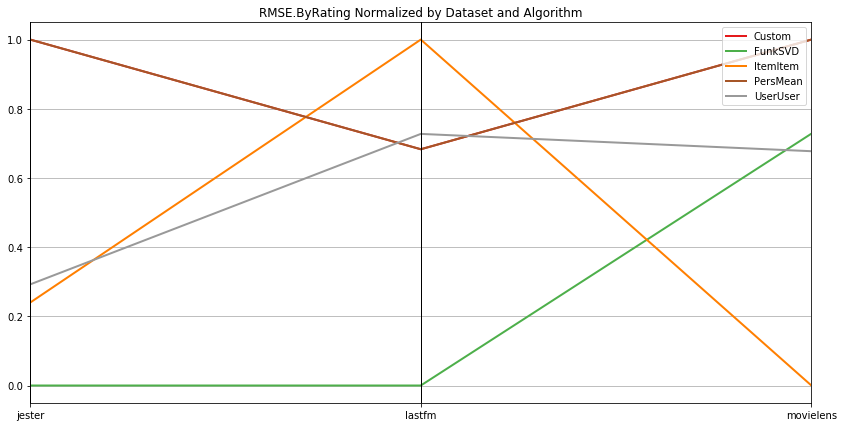

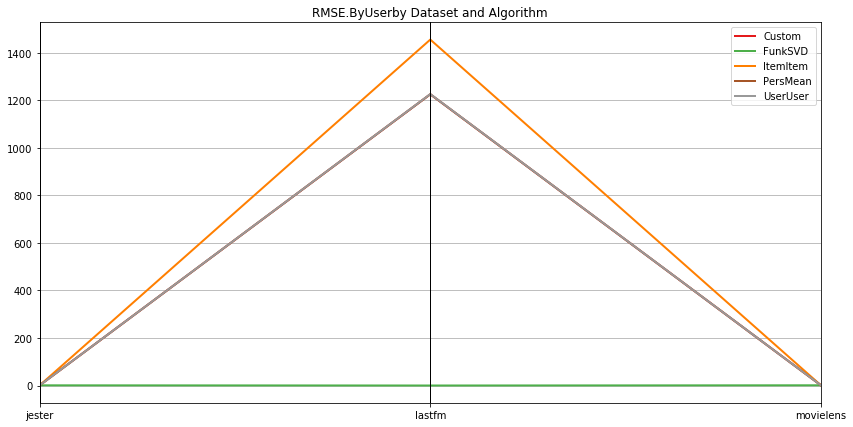

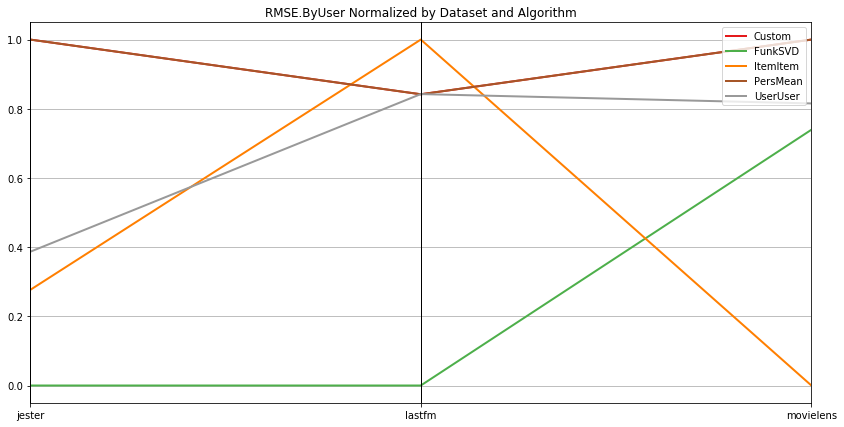

In [241]:
print_metric('RMSE.ByRating')
print_metric('RMSE.ByUser')

### MRR

This metric measures the ranking quality of the algorithm. This metric gives particular good results for Jester. That seems to be caused by the reduced number of items in the dataset (only 100 jokes). We could say that it is easier to "guess" the correct ranking in Jester than in the other datasets because of it has less items to order. Also it’s curious that MRR result for Movielens using CF item-item are approximately 40 times better than the outcome for the same metric, the same dataset, but with other algorithms.


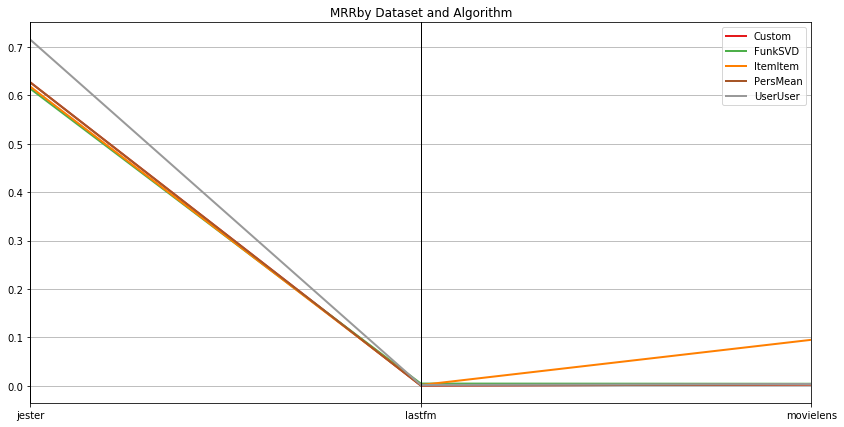

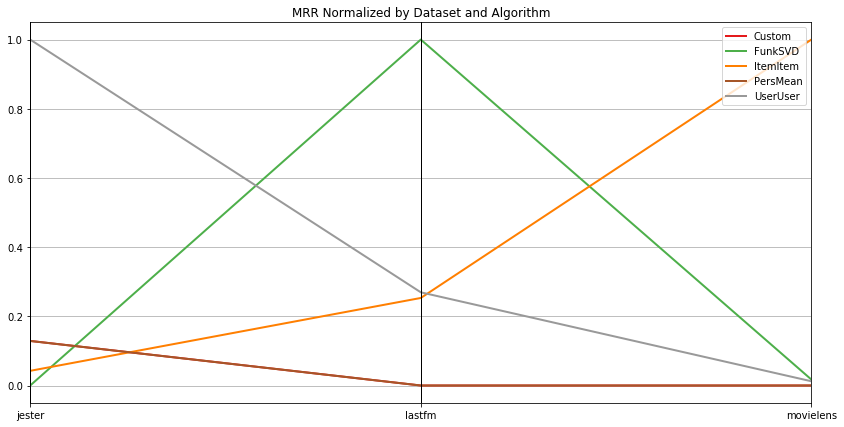

In [242]:
print_metric('MRR')

### nDCG

nDCG also reflects the ranking performance of an algorithm. For Jester and Movielens, we can see that it has a similar behavior to that of MRR. But in LastFM dataset, its worst result coincides with the best results of MRR.

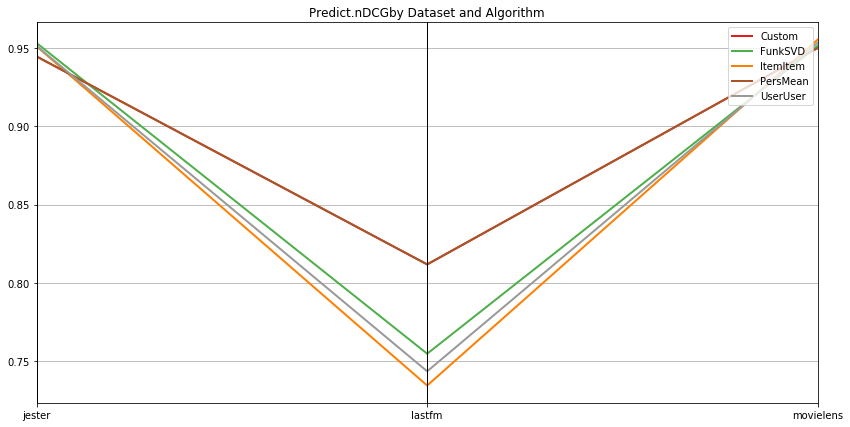

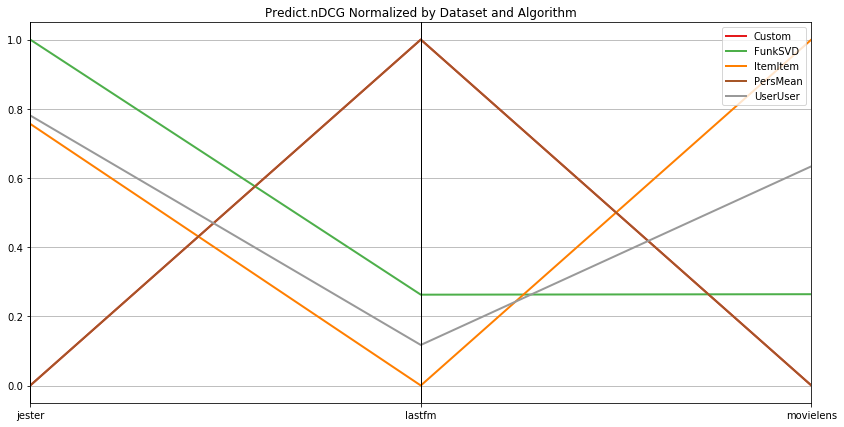

In [243]:
print_metric('Predict.nDCG')

## Algorithms
### CF Item-item
For the rating evaluations (MRR), CF Item-item is the algorithm with the best performance in LastFM and Movielens. But with Jester it is worse than CF User-user.

### PersMean
This algorithm has the best RMSE performance for Jester and Movielens, while in LastFM the other algorithms perform better.

### CF User-user
In general CF User-user has good, but not outstanding, RMSE results with Jester and Movielens. Also, in Jester the best MRR results are obtained by CF User-user.


## Conclusions

Although we didn’t do enough analysis to deduce solid conclusions, we can see that the behavior of the algorithms with LastFM is notoriously different to the one with the other datasets. This is probably a consequence of the fact that the relation between user-item is not an explicit eval- uation, like in the other datasets, it is the number of times the user listened to the item (artist). Nevertheless, our intention is to perform grid-search, in order to obtained stronger conclusions.